In [2]:
mycwd = 'C:\\Users\\u0137935\\source\\repos\\PaulESAT\\sounds-phd'

import numpy as np
import sys, os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(mycwd, '_general_fcts')))
from mySTFT.calc_STFT import calcSTFT, calcISTFT
sys.path.append(os.path.abspath(os.path.join(mycwd, '01_algorithms\\01_NR\\01_centralized\\01_MWF_based\\01_GEVD_MWF\\MWFpack')))
import VAD
import sig_gen

In [3]:
path_acoustic_scenarios = 'C:\\Users\\u0137935\\source\\repos\\PaulESAT\\sounds-phd\\02_data\\01_acoustic_scenarios'  # path to acoustic scenarios
speech_in = 'libri'     # name of speech signals library to be used
noise_type = 'white'    # type of noise to be used
#
Tmax = 5               # maximum signal duration [s]
baseSNR = 10            # SNR pre-RIR application [dB]
#
pauseDur = 1            # duration of pauses in-between speech segments [s]
pauseSpace = 1          # duration of speech segments (btw. pauses) [s]

# ----- Acoustic scenario + specific speech/noise signal(s) selection
ASref = 'J5_Ns1_Nn1\\AS9'       # acoustic scenario (if empty, random selection)
# ASref = 'testAS_anechoic'     # acoustic scenario (if empty, random selection)
# ASref = ''                    # acoustic scenario (if empty, random selection)
# speech = ''                    # speech signals (if empty, random selection)
speech1 = 'C:\\Users\\u0137935\\Dropbox\\BELGIUM\\KU Leuven\\SOUNDS_PhD\\02_research\\03_simulations\\99_datasets\\01_signals\\01_LibriSpeech_ASR\\test-clean\\61\\70968\\61-70968-0000.flac'
speech2 = 'C:\\Users\\u0137935\\Dropbox\\BELGIUM\\KU Leuven\\SOUNDS_PhD\\02_research\\03_simulations\\99_datasets\\01_signals\\01_LibriSpeech_ASR\\test-clean\\61\\70968\\61-70968-0001.flac'
speech = [speech1,speech2]
noise1 = 'C:\\Users\\u0137935\\Dropbox\\BELGIUM\\KU Leuven\\SOUNDS_PhD\\02_research\\03_simulations\\99_datasets\\01_signals\\99_noises\\white_Fs16e3\\whitenoise1.wav'
noise2 = 'C:\\Users\\u0137935\\Dropbox\\BELGIUM\\KU Leuven\\SOUNDS_PhD\\02_research\\03_simulations\\99_datasets\\01_signals\\99_noises\\white_Fs16e3\\whitenoise2.wav'
noise3 = 'C:\\Users\\u0137935\\Dropbox\\BELGIUM\\KU Leuven\\SOUNDS_PhD\\02_research\\03_simulations\\99_datasets\\01_signals\\99_noises\\white_Fs16e3\\whitenoise3.wav'
noise = [noise1,noise2,noise3]

# STFT
L = 2**9                        # Time frame length [samples]
R = L/2                         # Inter-frame overlap length [samples]
win = np.sqrt(np.hanning(L))    # STFT time window

In [4]:
y,ds,ny,t,Fs,reftxt = sig_gen.sig_gen(path_acoustic_scenarios,speech_in,Tmax,noise_type,baseSNR,\
                        pauseDur,pauseSpace,ASref,speech,noise)

Loading acoustic scenario: 6.3x5.9x3.5 m^3; alpha = 0.38...


Too many speech files references were provided. Using first 1.
Too many noise files references were provided. Using first 1.


In [5]:
Ymat = calcSTFT(y, Fs, win, L, R, sides='onesided')[0]
Dmat = calcSTFT(ds, Fs, win, L, R, sides='onesided')[0]

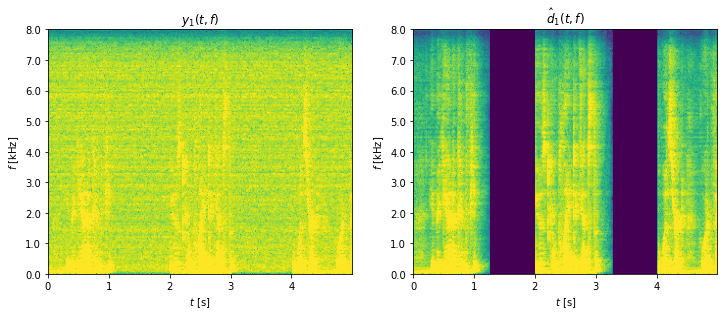

In [6]:
# VISUALIZE

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 4.5, forward=True)   # figure size
vminn = -120.0
vmaxx = 0.0

sensoridx = 0

# Raw microphone signal
ax[0].imshow(20*np.log10(np.abs(np.squeeze(Ymat[:,:,sensoridx]))), extent=[0, t[-1], Fs/2, 0], vmin=vminn, vmax=vmaxx)
ax[0].invert_yaxis()
ax[0].set_aspect('auto')
ax[0].set(xlabel='$t$ [s]', ylabel='$f$ [kHz]',
    title='$y_%i(t,f)$' % (sensoridx+1))
ax[0].axes.yaxis.set_ticks(np.arange(0,Fs/2+1e3,1e3))
ax[0].axes.yaxis.set_ticklabels([str(ii) for ii in np.arange(0,Fs/1e3/2 + 1)])
# Target microphone signal
ax[1].imshow(20*np.log10(np.abs(np.squeeze(Dmat[:,:,sensoridx]))), extent=[0, t[-1], Fs/2, 0], vmin=vminn, vmax=vmaxx)
ax[1].invert_yaxis()
ax[1].set_aspect('auto')
ax[1].set(xlabel='$t$ [s]', ylabel='$f$ [kHz]',
    title='$\hat{d}_%i(t,f)$' % (sensoridx+1))
ax[1].axes.yaxis.set_ticks(np.arange(0,Fs/2+1e3,1e3))
ax[1].axes.yaxis.set_ticklabels([str(ii) for ii in np.arange(0,Fs/1e3/2 + 1)])

stop = 1

Computing SNR on time section 1/62
Computing SNR on time section 11/62
Computing SNR on time section 21/62
Computing SNR on time section 31/62
Computing SNR on time section 41/62
Computing SNR on time section 51/62
Computing SNR on time section 61/62


C:\Users\U01379~1\AppData\Local\Temp/ipykernel_6864/1173911043.py:39: RuntimeWarning: Mean of empty slice
  std_across_nodes = np.nanmean(SNR, axis=2)


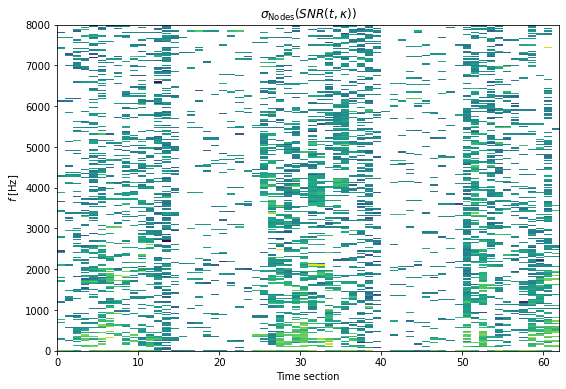

In [74]:
# VAD
tw = 0             # window length [s]
ref_sensor = 0          # index of reference sensor
VAD_fact = 400          # VAD threshold factor w.r.t. max(y**2)

# Time sections
Ns = 10       # Nr. of STFT frames in section
Nss = Ns/2    # Nr. of STFT frames overlapping between sections
Nts = int(np.floor(Ymat.shape[1]/Nss))   # Nr. of time sections

# Get SNR per frequency line for each time section
SNR = np.zeros((Nts,Ymat.shape[0],Ymat.shape[-1]))

for tt in range(Nts):
    
    if tt % 10 == 0:
        print('Computing SNR on time section %i/%i' % (tt+1,Nts))
    
    idx_ts = np.arange(tt*(Ns - Nss), np.amin((tt*(Ns - Nss) + Ns, Ymat.shape[1])), dtype=int)
    Ymat_ts = Ymat[:,idx_ts,:]
    Dmat_ts = Dmat[:,idx_ts,:]
    
    oVAD = np.zeros_like(Dmat_ts, dtype=float)
    
    for m in range(Ymat.shape[-1]):
        for ii in range(Ymat.shape[0]):
            Ybin = np.squeeze(Ymat_ts[ii,:,m])
            Dbin = np.squeeze(Dmat_ts[ii,:,m])
            thrs_E = np.amax(Dbin**2)/VAD_fact 

            oVAD[ii,:,m] = VAD.oracleVAD(Dbin,tw,thrs_E,Fs,plotVAD=False)[0]
            SNR[tt,ii,m] = VAD.getSNR(Ybin,oVAD[ii,:,m],silent=True)
            
# VISUALIZE

SNR[SNR == np.inf] = np.nan
SNR[SNR == -np.inf] = np.nan
std_across_nodes = np.nanstd(SNR, axis=2)
std_across_nodes = np.nanmean(SNR, axis=2)

fig, ax = plt.subplots(figsize=(9, 6))

# VAD
mapp = ax.imshow(std_across_nodes.T,extent=[0, Nts, Fs/2, 0], interpolation='None')
ax.invert_yaxis()
ax.set_aspect('auto')
ax.set(xlabel='Time section', ylabel='$f$ [Hz]', title='$\\sigma_{\\mathrm{Nodes}}(SNR(t,\\kappa))$')

stop =1

In [60]:
SNR.shape

(31, 257, 5)

In [55]:
std_across_nodes

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
# VISUALIZE

fig, ax = plt.subplots(1,2)

# Raw microphone signal
ax[0].imshow(SNR)
ax[0].invert_yaxis()
ax[0].set_aspect('auto')
ax[0].set(xlabel='Mic number', ylabel='Frame', title='SNR(l,m)')
#
# ax.imshow(20*np.log10(np.abs(np.squeeze(Ymat[:,:,sensoridx]))), extent=[0, t[-1], Fs/2, 0], vmin=vminn, vmax=vmaxx)
# ax.invert_yaxis()
# ax.set_aspect('auto')
# ax.set(xlabel='$t$ [s]', ylabel='$f$ [kHz]',
#     title='$y_%i(t,f)$' % (sensoridx+1))
# ax.axes.yaxis.set_ticks(np.arange(0,Fs/2+1e3,1e3))
# ax.axes.yaxis.set_ticklabels([str(ii) for ii in np.arange(0,Fs/1e3/2 + 1)])

In [ ]:
import numpy as np
a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.array([7,8,9])

np.stack((a,b,c))